In [190]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, root_mean_squared_error

from pgmpy.estimators import HillClimbSearch
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

## Обработка данных

### Загрузка данных

In [99]:
df = pd.read_csv('student-performance-multiple-linear-regression\Student_Performance.csv')
df.sample(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
3511,4,85,Yes,7,4,64.0
965,7,73,Yes,8,2,64.0
2430,4,77,Yes,8,0,62.0
6995,7,72,No,8,6,65.0
8057,7,47,No,6,7,37.0


Датасет 'Student Performance' доступен по [ссылке](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression/data).

Признаки:

| Признак | Описание | Тип значений (область значений) |
|---------|----------|----------|
| **Hours Studied** | Количество часов, потраченных студентом на подготовку | `int64` ({1,...9}) |
| **Previous Scores** | Оценка студента за предыдущие тесты | `int64` ({40,...99}) |
| **Extracurricular Activities** | Участвует ли студент во внеучебных активностях | `object` ({'Yes', 'No'}) |
| **Sleep Hours** | Среднесуточное количество часов сна студента | `int64` ({4,...9}) |
| **Sample Question Papers Practiced** | Количество демонстрационных вариантов работы, прорешанных студентом | `int64` ({0,...9}) |

Целевой признак:

**Performance Index** - показатель общей успеваемости каждого учащегося. Индекс успеваемости отражает академическую успеваемость учащегося и округляется до ближайшего целого числа. Индекс варьируется от 10 до 100, более высокие значения указывают на лучшую успеваемость. Тип значений - `float64`.

### Проверка пропущенных и NaN-значений

In [100]:
k_col_skips = df.loc[:, df.isna().any()].isna().sum()

print('Columns with skips:')
print(k_col_skips)

Columns with skips:
Series([], dtype: float64)


### Проверка типов признаков

In [101]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

### Преобразование категориальных признаков к количественным

In [102]:
print('Set of values of "Extracurricular Activities": ', df['Extracurricular Activities'].unique())

Set of values of "Extracurricular Activities":  ['Yes' 'No']


In [103]:
df_num = df.copy()
df_num['Extracurricular Activities'], codes = pd.factorize(df['Extracurricular Activities'], sort=True)
df_num.head(5)

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


In [104]:
print(list(codes))

['No', 'Yes']


### Одномерный анализ данных

В визуализации для удобства восприятия используются:
- ненормализованные данные,
- для количественных признаков с малым диапазоном значений построение `countplot`.

In [105]:
df_num.describe()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,0.494800,6.530600,4.583300,55.224800
std,2.589309,17.343152,0.499998,1.695863,2.867348,19.212558
min,1.000000,40.000000,0.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,0.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,0.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,1.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,1.000000,9.000000,9.000000,100.000000


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

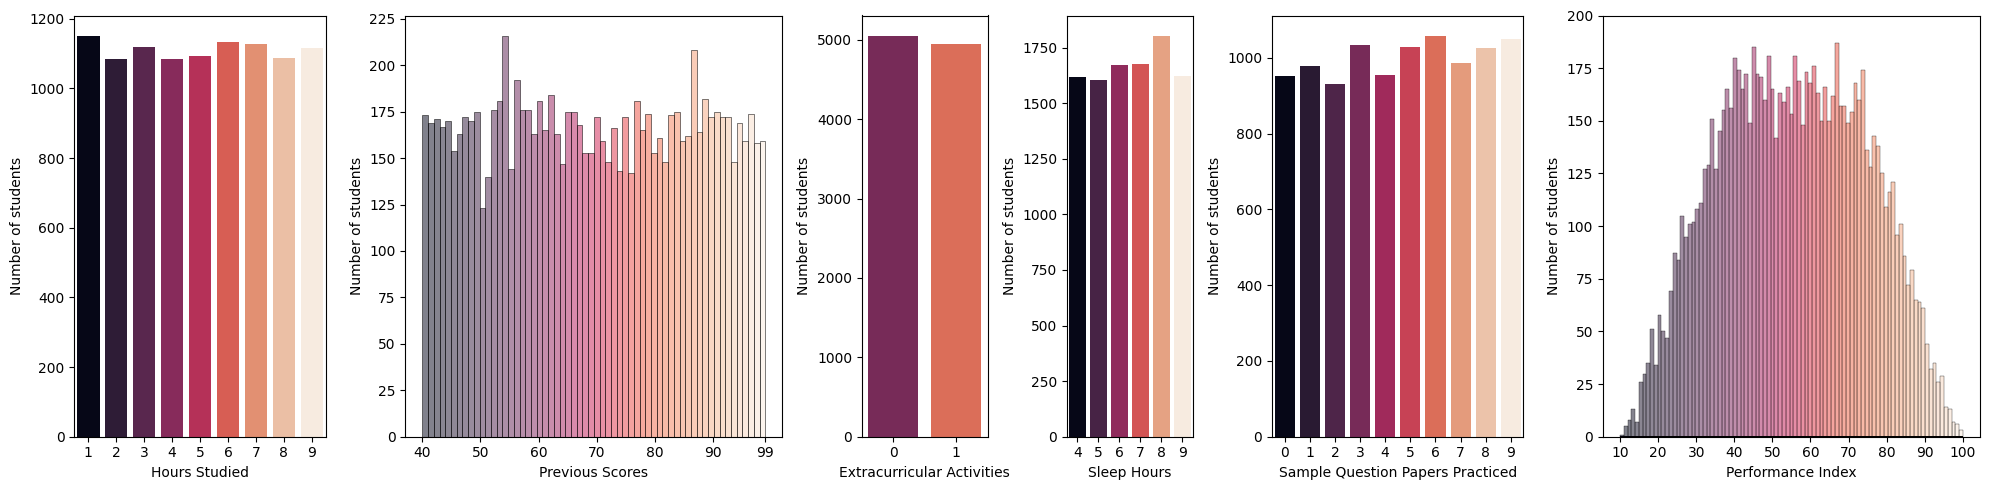

In [106]:
f, axs = plt.subplots(1, df_num.columns.size, figsize=(20, 5), width_ratios=[2, 3, 1, 1, 2, 3])
for i in [1, 5]:
    sns.histplot(data=df_num, x=df_num.columns[i], hue=df_num.columns[i], palette='rocket', ax=axs[i], legend=False, bins=len(df_num[df_num.columns[i]].unique()))
    axs[i].set(ylabel='Number of students')
for i in [0, 2, 3, 4]:
    sns.countplot(data=df_num, x=df_num.columns[i], hue=df_num.columns[i], palette='rocket', ax=axs[i], legend=False)
    axs[i].set(ylabel='Number of students')
axs[1].set_xticks(list(range(40, 100, 10)) + [99])
axs[1].set_yticks(list(range(0, 226, 25)))
axs[5].set_xticks(list(range(10, 101, 10)))
axs[5].set_yticks(list(range(0, 201, 25)))
    
plt.tight_layout()  
plt.show() 

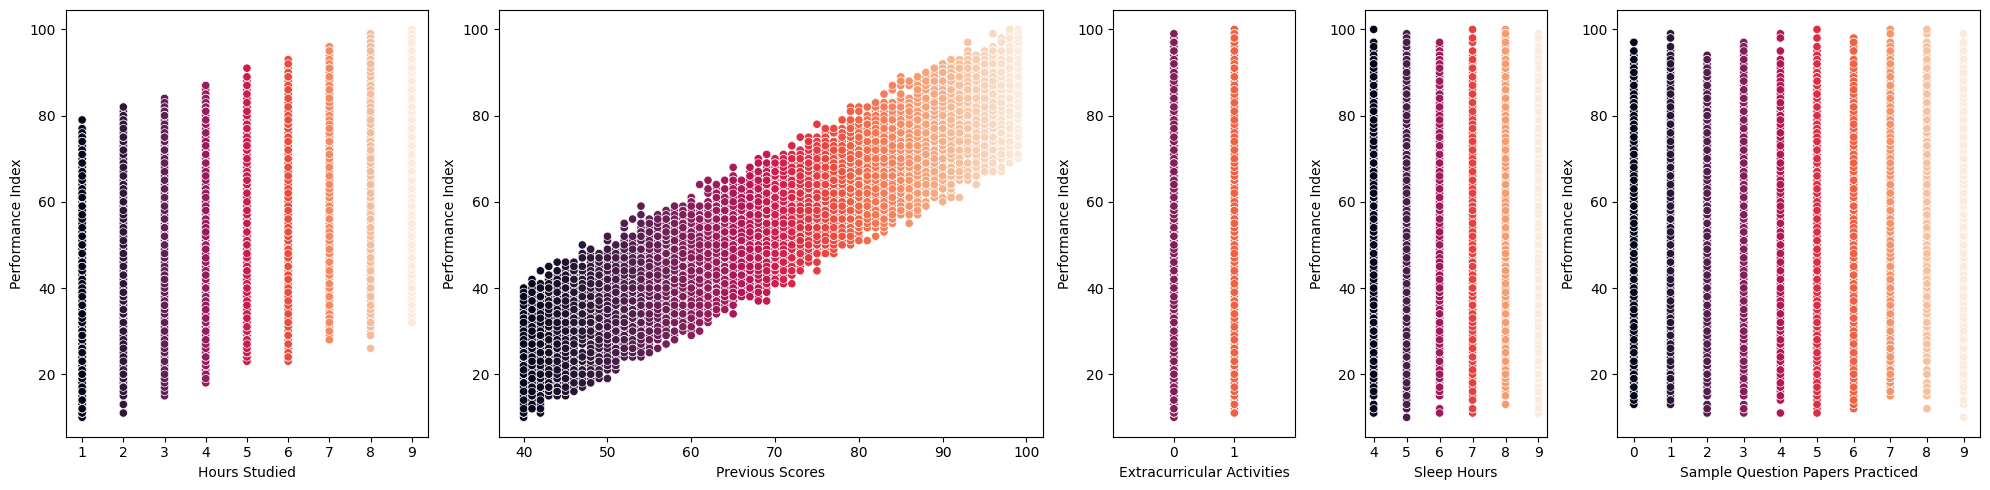

In [107]:
f, axs = plt.subplots(1, df_num.columns.size - 1, figsize=(20, 5), width_ratios=[2, 3, 1, 1, 2])
for i in range(5):
    sns.scatterplot(data=df_num, x=df_num.columns[i], y='Performance Index', hue=df_num.columns[i], palette='rocket', ax=axs[i], legend=False)
axs[0].set_xticks(list(range(1, 10)))
axs[2].set_xlim([-1, 2])
axs[2].set_xticks([0, 1])
axs[3].set_xticks(list(range(4, 10)))
axs[4].set_xticks(list(range(0, 10)))

plt.tight_layout()  
plt.show()

**Выводы:** 
- распределение объектов по классам по признакам за исключением целевого приблизительно равномерное,
- распределение объектов по классам по целевому признаку приблизительно гауссово,
- зависимость целевого признака от остальных визуально близка к линейной только для признаков `Previous Scores` и `Hours Studied`. Остальные признаки можно попробовать убрать при обучении.

### Двумерный анализ данных

Далее категориальный признак `Extracurricular activities` интепретируется как бинарный количественный.

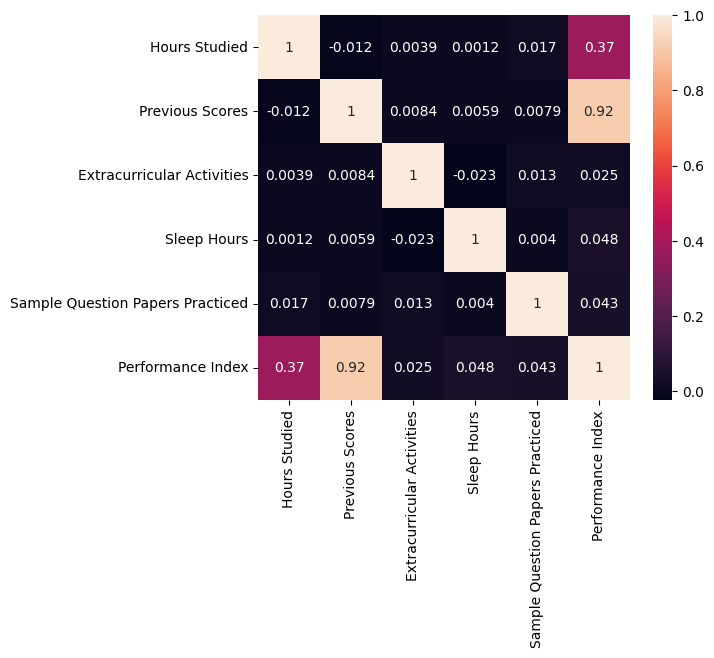

Largest absolute correlation value for every feature:
Hours Studied                       0.373730
Previous Scores                     0.915189
Extracurricular Activities          0.024525
Sleep Hours                         0.048106
Sample Question Papers Practiced    0.043268
Performance Index                   0.915189
dtype: float64


In [108]:
plt.figure(figsize=(6, 5))
corr_matr = df_num.corr()
sns.heatmap(corr_matr, cmap='rocket', annot=True)
plt.show()

print('Largest absolute correlation value for every feature:')
print(corr_matr.abs().where(corr_matr < 1).max())

**Выводы:** 
- целевой признак значительно коррелирует с признаками:
    1. `Previous Scores` (0.915189),
    2. `Hours Studied` (0.37373),
- нецелевые признаки коррелируют между собой пренебрежительно слабо:
    - корреляция  по модулю менее 0.25, 
    - со значением, близким к 0.25, коррелируют 2 пары признаков: 
        1. `Extracurricular Activities`, `Sleep Hours` (0.023284),
        2. `Hours Studied`, `Sample Question Papers Practiced` (0.017463).

## Обучение модели

### Разделение датасета на обучающую и тестировочную выборки

In [115]:
x_train, x_test, y_train, y_test = train_test_split(df_num.drop(columns=['Performance Index']), 
                                                    df_num['Performance Index'], 
                                                    test_size=0.25, 
                                                    random_state=1)
train = pd.concat([x_train, y_train], axis=1)
test = pd.concat([x_test, y_test], axis=1)

### Создание и обучение модели

In [116]:
estimator = HillClimbSearch(train)
model_structure = estimator.estimate()
model_structure.edges()

  0%|          | 9/1000000 [00:00<15:07:05, 18.37it/s]


OutEdgeView([('Hours Studied', 'Previous Scores'), ('Extracurricular Activities', 'Previous Scores'), ('Extracurricular Activities', 'Hours Studied'), ('Sleep Hours', 'Previous Scores'), ('Sleep Hours', 'Hours Studied'), ('Sample Question Papers Practiced', 'Previous Scores'), ('Sample Question Papers Practiced', 'Hours Studied'), ('Performance Index', 'Previous Scores'), ('Performance Index', 'Hours Studied')])

In [117]:
b_network = BayesianNetwork(model_structure.edges())
b_network.fit(train, estimator=MaximumLikelihoodEstimator)

### Визуализация модели

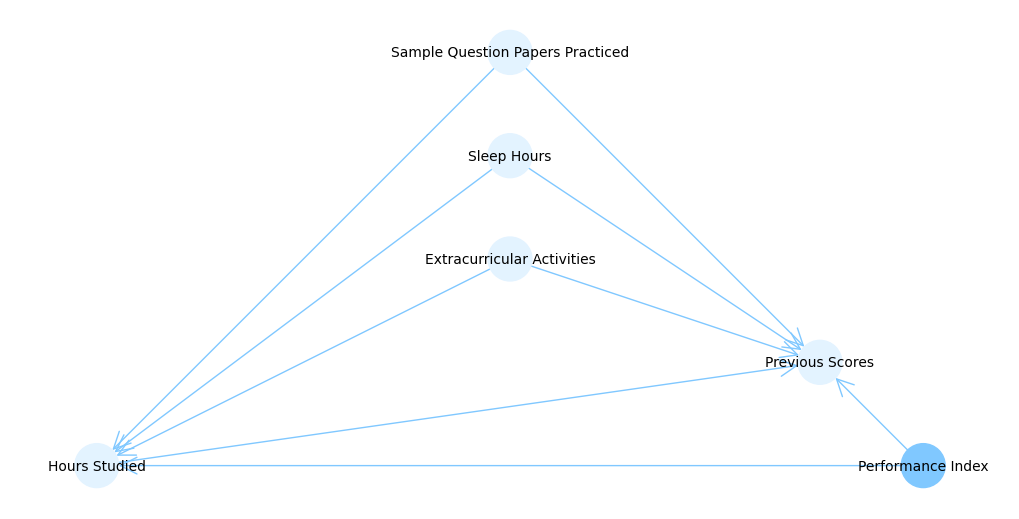

In [118]:
b_network_graph = nx.DiGraph()
b_network_graph.add_edges_from(b_network.edges())

plt.figure(figsize=(10, 5))
pos = nx.planar_layout(b_network_graph)
node_colors = ['#e3f3ff']*5 + ['#80c8ff']
nx.draw(b_network_graph, pos,
        with_labels=True, 
        node_color=node_colors, node_size=1000, font_size=10,
        edge_color='#80c8ff', arrowsize=30, arrowstyle='->'
)
plt.show()

### Апостериорный вывод

In [168]:
inference = VariableElimination(b_network)

n_tests = 5
test_queries = x_test.head(n_tests)
for i in range(n_tests):
    test_index = test_queries.index[i]
    test_evidence = test_queries.loc[test_index].to_dict()
    posterior = inference.query(variables=['Performance Index'], 
                                evidence=test_evidence)
    print(f'Test {i+1}: \n\
          Evidence: {test_evidence} \n\
          Performance Index with largest posterior probability for given evidence: {np.argmax(posterior.values)+10}, prob={posterior.values.max():0,.10f}\n\
          Top-5 values for Performance Index sorted by posterior probability:     {np.argsort(posterior.values)[-5:][::-1]+10} \n\
          Expected Performance Index: {y_test.loc[test_index]} \n')

Test 1: 
          Evidence: {'Hours Studied': 6, 'Previous Scores': 73, 'Extracurricular Activities': 0, 'Sleep Hours': 7, 'Sample Question Papers Practiced': 2} 
          Performance Index with largest posterior probability for given evidence: 45, prob=0.0391673514
          Top-5 values for Performance Index sorted by posterior probability:     [45 60 40 61 54] 
          Expected Performance Index: 58.0 

Test 2: 
          Evidence: {'Hours Studied': 1, 'Previous Scores': 89, 'Extracurricular Activities': 1, 'Sleep Hours': 7, 'Sample Question Papers Practiced': 2} 
          Performance Index with largest posterior probability for given evidence: 41, prob=0.0420347243
          Top-5 values for Performance Index sorted by posterior probability:     [41 49 52 61 50] 
          Expected Performance Index: 64.0 

Test 3: 
          Evidence: {'Hours Studied': 3, 'Previous Scores': 97, 'Extracurricular Activities': 1, 'Sleep Hours': 8, 'Sample Question Papers Practiced': 0} 
        

### Подсчет метрик

Для `Precision`, `Recall` и `F1` используются взвешенные обобщения для мультиклассовой классификации.

In [191]:
prediction = []
for i in range(x_test.shape[0]):
    posterior = inference.query(variables=['Performance Index'], 
                                evidence=x_test.loc[x_test.index[i]].to_dict())
    prediction.append(np.argmax(posterior.values)+10)

In [196]:
metrics = pd.DataFrame({
    'Accuracy': accuracy_score(y_test, prediction),
    'Precision': precision_score(y_test, prediction, average='weighted', zero_division=0.0),
    'Recall': recall_score(y_test, prediction, average='weighted', zero_division=0.0),
    'F1': f1_score(y_test, prediction, average='weighted'),
    'RMSE': root_mean_squared_error(y_test, prediction)
}, index=['bayes_network'])
metrics

,Accuracy,Precision,Recall,F1,RMSE
bayes_network,0.032,0.132559,0.032,0.027947,20.138868


### Сравнение со случайным классификатором

In [198]:
random_prediction = np.random.randint(10, 100, x_test.shape[0])
metrics.loc['random'] = [accuracy_score(y_test, random_prediction),
                         precision_score(y_test, random_prediction, average='weighted', zero_division=0.0),
                         recall_score(y_test, random_prediction, average='weighted', zero_division=0.0),
                         f1_score(y_test, random_prediction, average='weighted'),
                         root_mean_squared_error(y_test, random_prediction)]
metrics

,Accuracy,Precision,Recall,F1,RMSE
bayes_network,0.0320,0.132559,0.0320,0.027947,20.138868
random,0.0124,0.017109,0.0124,0.013579,32.756270


Все полученные метрики байесовской сети лучше таковых для случайного классификатора. Примечательно, что `RMSE` ниже в 1.5 раза.